# Generalizing a Taylor Recurrence

In [1]:
from sumpy.recurrence import _make_sympy_vec, get_processed_and_shifted_recurrence

from sumpy.expansion.diff_op import (
    laplacian,
    make_identity_diff_op,
)

from sumpy.recurrence import get_recurrence, recurrence_from_pde, shift_recurrence, get_shifted_recurrence_exp_from_pde, _extract_idx_terms_from_recurrence

import sympy as sp
from sympy import hankel1

import numpy as np

import math

import matplotlib.pyplot as plt
from matplotlib import cm, ticker

In [2]:
var = _make_sympy_vec("x", 2)
s = sp.Function("s")
n = sp.symbols("n")
i = sp.symbols("i")

In [3]:
def compute_derivatives(p):
    var = _make_sympy_vec("x", 2)
    var_t = _make_sympy_vec("t", 2)
    g_x_y = sp.log(sp.sqrt((var[0]-var_t[0])**2 + (var[1]-var_t[1])**2))
    derivs = [sp.diff(g_x_y,
                        var_t[0], i).subs(var_t[0], 0).subs(var_t[1], 0)
                        for i in range(p)]
    return derivs

In [4]:
def compute_derivatives_h2d(p, k=1.0):
    var = _make_sympy_vec("x", 2)
    var_t = _make_sympy_vec("t", 2)
    abs_dist = sp.sqrt((var[0]-var_t[0])**2 +
                        (var[1]-var_t[1])**2)
    g_x_y = (1j/4) * hankel1(0, k * abs_dist)
    derivs_helmholtz = [sp.diff(g_x_y,
                        var_t[0], i).subs(var_t[0], 0).subs(var_t[1], 0)
                                                for i in range(p)]
    return derivs_helmholtz

In [5]:
w = make_identity_diff_op(2)
laplace2d = laplacian(w)

w = make_identity_diff_op(2)
helmholtz2d = laplacian(w) + w

derivs_lap = compute_derivatives(8)
derivs_helm = compute_derivatives_h2d(8)

In [6]:
def get_grid(recur, order):
    poly_in_s_n = sp.poly(recur, [s(n-i) for i in range(order)])
    coeff_s_n = [poly_in_s_n.coeff_monomial(poly_in_s_n.gens[i]) for i in range(order)]

    table = []
    for i in range(len(coeff_s_n)):
        table.append(sp.poly(coeff_s_n[i], var[0]).all_coeffs()[::-1])

    return table

def convert(grid):
    recur_exp = 0
    i = sp.symbols("i")
    s_terms = []
    for j in range(len(grid)):
        for k in range(len(grid[j])):
            recur_exp += grid[j][k] * s(n-j,i-k)/sp.factorial(i-k)
            if grid[j][k] != 0:
                s_terms.append((j,k))
    return recur_exp, s_terms

def grid_recur_to_column_recur(grid_recur, s_terms):
    grid_recur_simp = grid_recur
    bag = set()
    for s_t in s_terms:
        bag.add(-((0-s_t[0])-s_t[1]))
        grid_recur_simp = grid_recur_simp.subs(s(n-s_t[0],i-s_t[1]), (-1)**(s_t[1])*s((n-s_t[0])-s_t[1],(i-s_t[1])+s_t[1]))
    shift = min(bag)
    return sp.solve(sp.simplify(grid_recur_simp * sp.factorial(i)).subs(n, n+shift), s(n,i))[0]

def get_taylor_recurrence(pde):
    recur, order = get_shifted_recurrence_exp_from_pde(pde)
    grid = get_grid(recur, order)
    grid_recur, s_terms = convert(grid)
    column_recur = grid_recur_to_column_recur(grid_recur, s_terms)
    return column_recur

In [7]:
def create_subs_grid(width, length, derivs, coord_dict):
    initial_grid = [[sp.diff(derivs[i], var[0], j).subs(var[0], 0) for j in range(width)] for i in range(length)]

    # assume len(initial_grid) >= 1
    initial_grid_subs = []
    initial_grid_width = len(initial_grid[0])
    initial_grid_length = len(initial_grid)

    for i_x in range(initial_grid_length):
        tmp = []
        for j_x in range(initial_grid_width):
            tmp.append((initial_grid[i_x][j_x].subs(var[1],coord_dict[var[1]])).evalf())
        initial_grid_subs.append(tmp)
    
    return initial_grid_subs


In [8]:
def extend_grid(initial_grid_in, grid_recur, coord_dict, n_derivs_compute, order_grid_recur):
    initial_grid_subs = [row[:] for row in initial_grid_in] #deep copy

    initial_grid_width = len(initial_grid_subs[0])
    initial_grid_length = len(initial_grid_subs)

    for n_x in range(initial_grid_length, n_derivs_compute):
        appMe = []
        for i_x in range(initial_grid_width):
            exp_i_n = grid_recur.subs(n, n_x).subs(i, i_x)
            if exp_i_n == 0:
                exp_i_n = sp.diff(derivs_lap[n_x], var[0], i_x).subs(var[0], 0)
            assert n_x-order_grid_recur >= 0
            kys = [s(n_x-k,i_x) for k in range(1,order_grid_recur+1)]
            vals = [initial_grid_subs[n_x-k][i_x] for k in range(1, order_grid_recur+1)]
            my_dict = dict(zip(kys, vals))
            res = exp_i_n.subs(my_dict).subs(coord_dict)
            appMe.append(res)

        initial_grid_subs.append(appMe)

    return initial_grid_subs


In [9]:
def compute_taylor_lp(inp_grid, coord_dict):
    inp_grid = np.array(inp_grid)
    _, c = inp_grid.shape
    return np.sum(inp_grid * np.reshape(np.array([coord_dict[var[0]]**i/math.factorial(i) for i in range(c)]), (1, c)), axis = 1)

In [10]:
def compute_lp_orders(pde, loc, num_of_derivs, derivs_list, recur_order, taylor_order):
    var = _make_sympy_vec("x", 2)
    coord_dict_t = {var[0]: loc[0], var[1]: loc[1]}

    initial_grid_subs = create_subs_grid(taylor_order, recur_order, derivs_list, coord_dict_t)

    extended_grid = extend_grid(initial_grid_subs, get_taylor_recurrence(pde), coord_dict_t, num_of_derivs, recur_order)

    return compute_taylor_lp(extended_grid, coord_dict_t)

In [11]:
def evaluate_true(coord_dict, p, derivs_list):
    retMe = []
    for i in range(p):
        exp = derivs_list[i]
        f = sp.lambdify(var, exp)
        retMe.append(f(coord_dict[var[0]], coord_dict[var[1]]))
    return np.array(retMe)

In [16]:
def compute_error_coord_tg(loc, pde, derivs_list, n_of_derivs, taylor_order, recur_order):
    exp = compute_lp_orders(pde, loc, n_of_derivs+1, derivs_list, recur_order, taylor_order)
    coord_dict_test = {var[0]: loc[0], var[1]: loc[1]}
    true = evaluate_true(coord_dict_test, n_of_derivs+1, derivs_list)

    print((np.abs(exp[-1]-true[-1]).evalf()/np.abs(true[-1])).evalf())

    return (np.abs(exp[-1]-true[-1]).evalf()/np.abs(true[-1])).evalf()

In [17]:
def generate_error_grid(res, order_plot, pde, derivs, taylor_order, recur_order):
    x_grid = [10**(pw) for pw in np.linspace(-8, 0, res)]
    y_grid = [10**(pw) for pw in np.linspace(-8, 0, res)]
    res=len(x_grid)
    plot_me = np.empty((res, res))
    for i in range(res):
        for j in range(res):
            if abs(x_grid[i]) == abs(y_grid[j]):
                plot_me[i, j] = 1e-16
            else:
                plot_me[i,j] = compute_error_coord_tg(np.array([x_grid[i],y_grid[j]]), pde, derivs, order_plot, taylor_order, recur_order)
                if plot_me[i,j] == 0:
                    plot_me[i, j] = 1e-16
    return x_grid, y_grid, plot_me

In [18]:
x_grid, y_grid, plot_me_lap = generate_error_grid(8, 7, laplace2d, derivs_lap, 4, 2)

0.00184871819382009
4.75098133319462e-8
1.27376775023898e-12
1.24084614178700e-16
1.60573991798823e-16
6.23381244320551e-16
5.37798696669397e-16
26177090592573.4
0.00184871819382012
4.75098141342560e-8
1.27451910300311e-12
0
8.37458627366846e-16
0
6.04988962786002e+24
26177090592573.7
0.00184871819381942
4.75098135453250e-8
1.27428262748819e-12
2.75523191325844e-16
3.56545885702053e-16
1.62179238320148e+36
6.04988962786031e+24
26177090592574.3
0.00184871819382027
4.75098138141641e-8
1.27461083449562e-12
0
4.35075881796626e+47
1.62179238320148e+36
6.04988962786018e+24
26177090592573.2
0.00184871819382014
4.75098142305268e-8
1.27420964404018e-12
1.16717621539488e+59
4.35075881796630e+47
1.62179238320142e+36
6.04988962785993e+24
26177090592573.6
0.00184871819382024
4.75098137391397e-8
3.13117872506618e+70
1.16717621539492e+59
4.35075881796626e+47
1.62179238320144e+36
6.04988962786018e+24
26177090592574.3
0.00184871819381974
8.40000000000000e+81
3.13117872506629e+70
1.16717621539490e+59
4.

In [20]:
x_grid, y_grid, plot_me_helm = generate_error_grid(8, 7, helmholtz2d, derivs_helm, 4, 4)

0.00184871819382052
4.75098141096813e-8
1.27424113932491e-12
3.44431957713771e-17
6.31511332640171e-16
4.90570949474948e-16
5.87724883438792e-16
26177090592573.4
0.00184871819381963
4.75098144912018e-8
1.27493466971487e-12
5.81901218538308e-16
3.77301936958497e-16
4.46996650791360e-16
6.04988962786052e+24
26177090592576.2
0.00184871819377463
4.75098137869768e-8
1.27388870384998e-12
1.08208552419152e-15
3.86092650841635e-16
1.62179238322092e+36
6.04988962793290e+24
26177090592971.4
0.00184871818496024
4.75097716109870e-8
1.27474821246038e-12
3.16296324062824e-16
4.35075882804186e+47
1.62179238695728e+36
6.04988964188820e+24
26177090669288.2
0.00184871648322706
4.75016092694573e-8
1.22997606341039e-12
1.16717673725736e+59
4.35076076325769e+47
1.62179310833453e+36
6.04989233625298e+24
26177105403844.6
0.00184838788643231
4.58767733787243e-8
3.13144895876003e+70
1.16727694753693e+59
4.35113430648643e+47
1.62193235151123e+36
6.05041241365264e+24
26179949654208.7
0.00178300550681144
8.538076

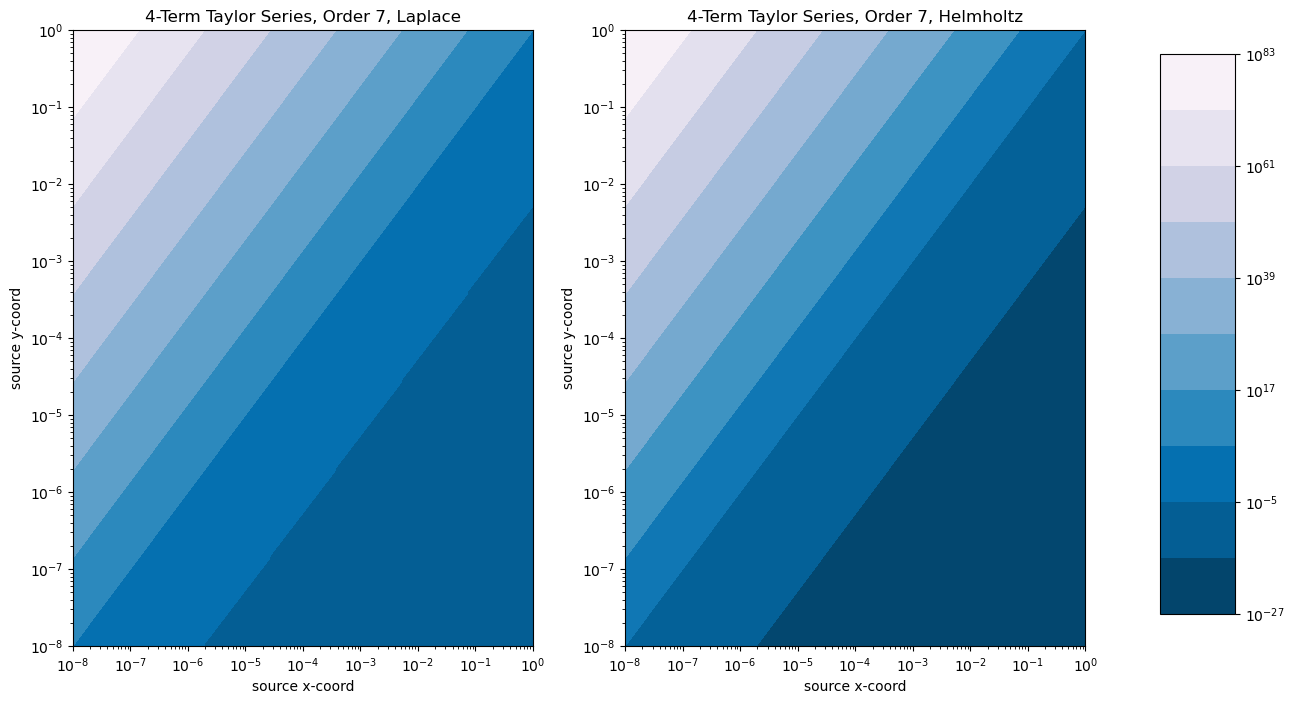

In [22]:
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8))
cs1 = ax1.contourf(x_grid, y_grid,plot_me_lap, locator=ticker.LogLocator(), cmap=cm.PuBu_r)

cs2 = ax2.contourf(x_grid, y_grid, plot_me_helm, locator=ticker.LogLocator(), cmap=cm.PuBu_r)

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(cs1, cax=cbar_ax)


ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel("source x-coord")
ax1.set_ylabel("source y-coord")


ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel("source x-coord")
ax2.set_ylabel("source y-coord")

ax1.set_title('4-Term Taylor Series, Order 7, Laplace')
ax2.set_title('4-Term Taylor Series, Order 7, Helmholtz')

plt.show()